## Composite Pulses

This notebook aims to study composite pulses. It starts by defining three functins which refer to the composite pulse sequences defined as BB1, Knill-Pulse and the broadband and narrowbrand composite pulses defined in [1] for $\pi$ pulses. After defining these, we first demonstrate the validity of the composite pulse sequence defined in [1] for changes in the duration of the pulse and furthermore validate it also for amplitude, as it is done in [1]. The results are consistent with those presented in [1]. 

[1]Boyan T. Torosov e Nikolay V. Vitanov. “Experimental demonstration of composite pulses on
IBM’s quantum computer”. Em: (2022). arXiv: 2202.09647 [quant-ph].



In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options
from qiskit import QuantumCircuit
from qiskit import pulse, transpile, schedule, assemble
from qiskit.pulse.library import Gaussian
from qiskit.visualization import plot_histogram

import numpy as np
from qiskit.circuit import Gate, Parameter
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram

In [3]:
session = QiskitRuntimeService()
backend_real = session.get_backend('ibm_osaka')

In [4]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator

simulator_basic = BasicSimulator()
simulator_aer = AerSimulator()

In [115]:
inst_map = backend_real.defaults().instruction_schedule_map
inst_map.get('x', qubits = [0])

Schedule((0, Play(Drag(duration=120, sigma=30, beta=-0.2856440017996339, amp=0.18656070201057046, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), name="x")

In [8]:
def BB1pulse(theta, phi, amplitude, duration, sigma, qubit = 0):
    
    beta = np.arccos(-(theta/(np.pi*4)))
    
    with pulse.build(backend_real) as FirstPulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)

        pulse.play(pulse.Gaussian(duration = duration, amp=(amplitude/2), sigma = sigma), drive_chan)
    
    
    with pulse.build(backend_real) as BetaShift:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
        pulse.shift_phase(-beta, drive_chan)
        pulse.play(pulse.Gaussian(duration = duration, amp=amplitude, sigma = sigma), drive_chan)
        pulse.shift_phase(beta, drive_chan)
    
    with pulse.build(backend_real) as Beta3Shift:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
        pulse.shift_phase(-3*beta, drive_chan)
        pulse.play(pulse.Gaussian(duration = duration, amp=2*amplitude, sigma = sigma), drive_chan)
        pulse.shift_phase(3*beta, drive_chan)
    
    
    with pulse.build(backend = backend_real, default_alignment = 'sequential', name = 'CP-BB1 Experiment') as bb1_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
    
        pulse.call(FirstPulse) 
        pulse.call(BetaShift)
        pulse.call(Beta3Shift)
        pulse.call(BetaShift)
        pulse.call(FirstPulse)
    
    return bb1_sched
    
    

In [9]:
def KnillPulse(theta, phi, amplitude, duration, sigma, qubit =0 ):
### Pi pulse
    drive_amp = Parameter('drive_amp')
    with pulse.build(backend_real) as pipulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
        pulse.play(pulse.Gaussian(duration = duration, amp=amplitude, sigma = sigma), drive_chan)
    
### Pi pulse phase pi/6    
    with pulse.build(backend_real) as pipulse_pi6phase:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
        pulse.shift_phase(-np.pi/6, drive_chan)
        pulse.play(pulse.Gaussian(duration = duration, amp=amplitude, sigma = sigma), drive_chan)
        pulse.shift_phase(np.pi/6, drive_chan)
    
### Pi pulse phase pi/2 
    with pulse.build(backend_real) as pipulse_pi2phase:
    
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
        pulse.shift_phase(-np.pi/2, drive_chan)
        pulse.play(pulse.Gaussian(duration = duration, amp=amplitude, sigma = sigma), drive_chan)
        pulse.shift_phase(np.pi/2, drive_chan)
        
    with pulse.build(backend = backend_real, default_alignment = 'sequential') as knill_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
    
        pulse.call(pipulse_pi6phase)
        pulse.call(pipulse)
        pulse.call(pipulse_pi2phase)
        pulse.call(pipulse)
        pulse.call(pipulse_pi6phase)
        
    return knill_sched

In [10]:
### Broadband pulses defined in article:
def BBphases(N):
    phases =[]
    for k in range(1, N+1):
        phases.append(k*(k-1)*np.pi/N)

    return phases

def NBphases(N):
    phases = []
    for k in range(1, N+1):
        if k%2 == 0:
            phases.append(k*np.pi/N)
        elif k%2 != 0:
            phases.append(-(k-1)*np.pi/N)

    return phases



In [11]:
def ArticleCP(theta, phi, amplitude, duration, sigma, freq_opHz, phase_function, N, qubit =0):
    phase = phase_function(N)
    list_pulses = []
    if phase_function == NBphases:
        phase.reverse()
    for i in phase:
        with pulse.build(backend_real) as cp_pulse:
    
            drive_chan = pulse.drive_channel(qubit)
            pulse.set_frequency(freq_opHz, drive_chan)
            pulse.shift_phase(-i, drive_chan)
            pulse.play(pulse.Gaussian(duration = duration, amp=amplitude, sigma = sigma), drive_chan)
            pulse.shift_phase(i, drive_chan)
            
        list_pulses.append(cp_pulse)
        
    with pulse.build(backend = backend_real, default_alignment = 'sequential') as cp_sched:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(freq_opHz, drive_chan)
        for i in list_pulses:
            pulse.call(i)
    return cp_sched       
            

In [12]:
def create_circuit(pulse_schedule, parameter, list_parameter):
    qc = QuantumCircuit(1)
    custom_gate = Gate('custom_gate', 1, [parameter])
    qc.append(custom_gate,[0])# putting the custom gate in the qubit 0 in the Quantum Circuit
    qc.measure_all()

    qc.add_calibration(custom_gate, [0], pulse_schedule, [parameter])

    list_circuits = [qc.assign_parameters({parameter: a}, inplace = False) for a in list_parameter]
    
    return list_circuits


In [13]:
list_duration = [i*8 for i in range(15 - 10, 15+10)]
duration = 120; sigma = 30; amplitude_op = 0.18401147983514912 ;freq_opHz = 4.822607565331892*1e9

In [42]:
parameter_duration = Parameter('parameter_duration')
theta = np.pi
phi = 0
schedule_article = ArticleCP(theta, phi, amplitude_op, parameter_duration, sigma, freq_opHz,BBphases, 3, qubit =0)
circuits_N3 = create_circuit(schedule_article, parameter_duration, list_duration)

In [43]:
job_N3 = backend_real.run(circuits_N3, shots = 1024)
print(job_N3.job_id())

cs1cpx3kfpw00080da3g


In [44]:
result_counts = job_N3.result().get_counts()
probability_N3 = [i['1']/sum(i.values()) for i in result_counts]

In [57]:
list_duration2 = [i*8 for i in range(15 - 9, 15+9)]

cs1cv9n965y000850wfg


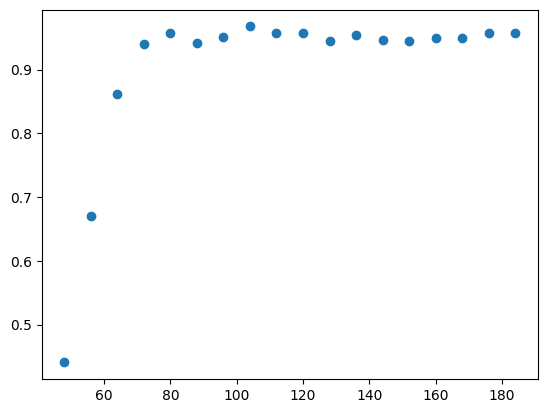

In [55]:
schedule_broad9 = ArticleCP(theta, phi, amplitude_op, parameter_duration, sigma, freq_opHz,BBphases, 9, qubit =0)
circuits_b9 = create_circuit(schedule_broad9, parameter_duration, list_duration)
job_b9 = backend_real.run(circuits_b9, shots = 1024)
print(job_b9.job_id())
result_counts_b9 = job_b9.result().get_counts()
probability_b9 = [i['1']/sum(i.values()) for i in result_counts_b9]
plt.scatter(list_duration, probability_b9)
plt.show()

cs1cw6875q40008tmw3g


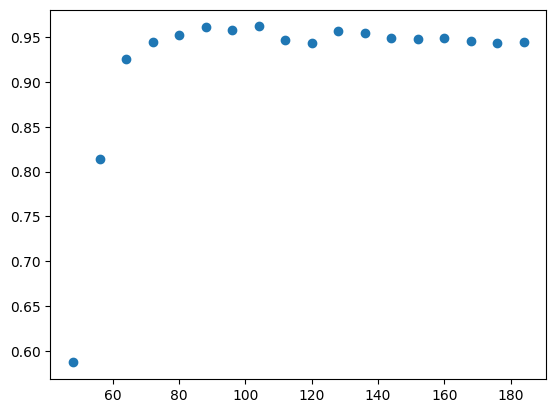

In [56]:
schedule_broad15 = ArticleCP(theta, phi, amplitude_op, parameter_duration, sigma, freq_opHz,BBphases, 15, qubit =0)
circuits_b15 = create_circuit(schedule_broad15, parameter_duration, list_duration)
job_b15 = backend_real.run(circuits_b15, shots = 1024)
print(job_b15.job_id())
result_counts_b15 = job_b15.result().get_counts()
probability_b15 = [i['1']/sum(i.values()) for i in result_counts_b15]
plt.scatter(list_duration, probability_b15)
plt.show()

cs1d8rbbqt7g0081wfwg


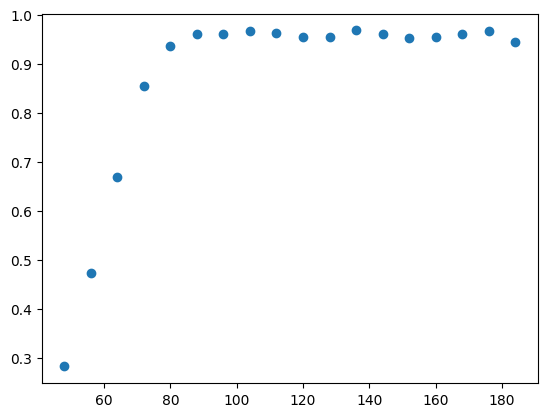

In [110]:
schedule_broad5 = ArticleCP(theta, phi, amplitude_op, parameter_duration, sigma, freq_opHz,BBphases, 5, qubit =0)
circuits_b5 = create_circuit(schedule_broad5, parameter_duration, list_duration2)
job_b5 = backend_real.run(circuits_b5, shots = 1024)
print(job_b5.job_id())
result_counts_b5 = job_b5.result().get_counts()
probability_b5 = [i['1']/sum(i.values()) for i in result_counts_b5]
plt.scatter(list_duration2, probability_b5)
plt.show()

In [79]:
schedule_single = ArticleCP(theta, phi, amplitude_op, parameter_duration, sigma, freq_opHz,BBphases, 1, qubit =0)
circuits_single = create_circuit(schedule_single, parameter_duration, list_duration)


cs1czge965y000850wv0


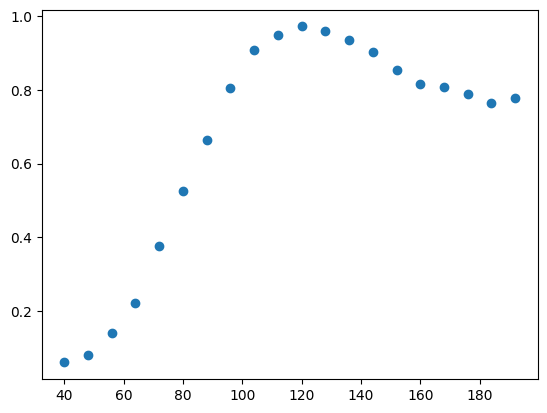

In [81]:
job_single = backend_real.run(circuits_single, shots = 1024)
print(job_single.job_id())
result_counts_single= job_single.result().get_counts()
probability_single = [i['1']/sum(i.values()) for i in result_counts_single]
plt.scatter(list_duration, probability_single)
plt.show()

In [99]:
dt = backend_real.configuration().dt
rabi_freq = theta/(duration*dt)
list_duration_dif = [i - duration for i in list_duration]
list_duration_dif2 = [i - duration for i in list_duration2]
list_rabif = [theta/(i*dt) for i in list_duration]
list_rabif2 = [theta/(i*dt) for i in list_duration2]
list_dif_rf2 = [(i - rabi_freq)/1e6 for i in list_rabif2]
list_dif_rf = [(i - rabi_freq)/1e6 for i in list_rabif]

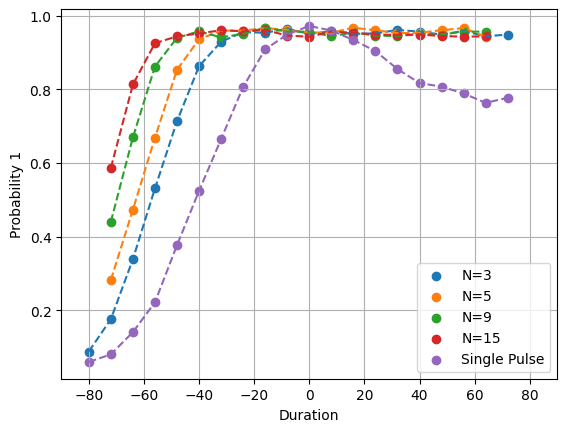

In [112]:
plt.scatter(list_duration_dif, probability_N3, label = 'N=3')
plt.plot(list_duration_dif, probability_N3, '--')

plt.scatter(list_duration_dif2, probability_b5, label = 'N=5')
plt.plot(list_duration_dif2, probability_b5, '--')

plt.scatter(list_duration_dif2, probability_b9, label = 'N=9')
plt.plot(list_duration_dif2, probability_b9, '--')
plt.scatter(list_duration_dif2, probability_b15, label = 'N=15')
plt.plot(list_duration_dif2, probability_b15, '--')
plt.scatter(list_duration_dif, probability_single, label = 'Single Pulse')
plt.plot(list_duration_dif, probability_single, '--')

plt.xlim(-90, 90)
plt.xlabel('Duration')
plt.ylabel('Probability 1')
plt.legend()
plt.grid()
plt.show()


In [20]:
erro_param = Parameter('erro_param')
list_erro = np.linspace(-1., +1., 30)

In [120]:
### Attempt with Amplitude:
erro_param = Parameter('erro_param')
list_erro = np.linspace(-1., +1., 30)
schedule_BB5_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,BBphases, 5, qubit =0)
circuits_BB5_amplitude = create_circuit(schedule_BB5_amplitude, erro_param, list_erro)


cs1r2fhyhpyg008aj1cg


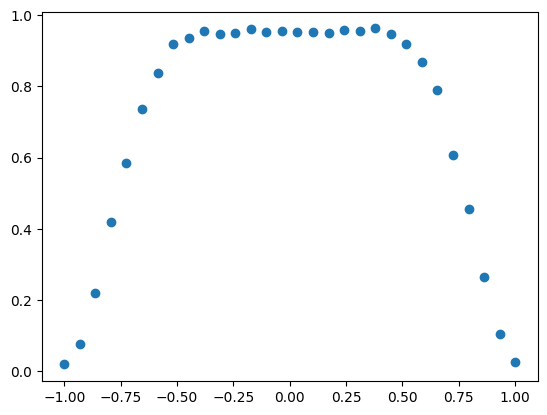

In [124]:
job_BB5_amplitude = backend_real.run(circuits_BB5_amplitude, shots = 1024)
print(job_BB5_amplitude.job_id())
result_counts_BB5_amplitude = job_BB5_amplitude.result().get_counts()
probability_BB5_amplitude = [i['1']/sum(i.values()) for i in result_counts_BB5_amplitude]
plt.scatter(list_erro, probability_BB5_amplitude)
plt.show()

In [24]:
job_BB5_amplitude = session.job('cs1r2fhyhpyg008aj1cg')
result_counts_BB5_amplitude = job_BB5_amplitude.result().get_counts()
probability_BB5_amplitude = [i['1']/sum(i.values()) for i in result_counts_BB5_amplitude]

In [25]:
schedule_BB3_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,BBphases, 3, qubit =0)
circuits_BB3_amplitude = create_circuit(schedule_BB3_amplitude, erro_param, list_erro)

schedule_BB9_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,BBphases, 9, qubit =0)
circuits_BB9_amplitude = create_circuit(schedule_BB9_amplitude, erro_param, list_erro)

schedule_BB15_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,BBphases, 15, qubit =0)
circuits_BB15_amplitude = create_circuit(schedule_BB15_amplitude, erro_param, list_erro)



In [26]:
all_three_circuits = circuits_BB3_amplitude + circuits_BB9_amplitude + circuits_BB15_amplitude



In [152]:
job_all_three = backend_real.run(all_three_circuits, shots = 1024)
job_all_three.job_id()

'cs1r9sqyhpyg008aj1xg'

In [27]:
job_all_three = session.job('cs1r9sqyhpyg008aj1xg')

In [162]:
len(circuits_BB15_amplitude)

30

In [28]:
counts_all_three = job_all_three.result().get_counts()
counts_BB3_amplitude = []
counts_BB9_amplitude = []
counts_BB15_amplitude = []
for i in range(len(counts_all_three)):
    if i < len(circuits_BB3_amplitude):
        counts_BB3_amplitude.append(counts_all_three[i])
    elif i < len(circuits_BB3_amplitude) + len(circuits_BB9_amplitude):
        counts_BB9_amplitude.append(counts_all_three[i])
    elif i < len(circuits_BB3_amplitude) + len(circuits_BB9_amplitude) + len(circuits_BB15_amplitude):
        counts_BB15_amplitude.append(counts_all_three[i])
        
prob_BB3_amplitude = [i['1']/sum(i.values()) for i in counts_BB3_amplitude]
prob_BB9_amplitude = [i['1']/sum(i.values()) for i in counts_BB9_amplitude]
prob_BB15_amplitude = [i['1']/sum(i.values()) for i in counts_BB15_amplitude]

len(prob_BB9_amplitude)

30

In [35]:
job_single_pulse = session.job('cs1ccntyhpyg008ah50g')
result_single_pulse = job_single_pulse.result().get_counts()
counts_single_pulse = []
counts_ignore = []
for i in range(60):
    if i%2 == 0:
        counts_single_pulse.append(result_single_pulse[i])
    else:
        counts_ignore.append(result_single_pulse[i])
prob_single_pulse = [i['1']/sum(i.values()) for i in counts_single_pulse]
ignore_p = [i['1']/sum(i.values()) for i in counts_ignore]


In [18]:
theta = np.pi; phi = 0

In [21]:
schedule_NB3_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,NBphases, 3, qubit =0)
circuits_NB3_amplitude = create_circuit(schedule_NB3_amplitude, erro_param, list_erro)

schedule_NB5_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,NBphases, 5, qubit =0)
circuits_NB5_amplitude = create_circuit(schedule_NB5_amplitude, erro_param, list_erro)

schedule_NB9_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,NBphases, 9, qubit =0)
circuits_NB9_amplitude = create_circuit(schedule_NB9_amplitude, erro_param, list_erro)

schedule_NB15_amplitude = ArticleCP(theta, phi, amplitude_op*(1 + erro_param), duration, sigma, freq_opHz,NBphases, 15, qubit =0)
circuits_NB15_amplitude = create_circuit(schedule_NB15_amplitude, erro_param, list_erro)



In [227]:
job_try_15 = backend_real.run(circuits_NB15_amplitude, shots = 1024)
print(job_try_15.job_id())

cs1s3kp75q40008tnwgg


In [44]:
job_try_15 = session.job('cs1s3kp75q40008tnwgg')

In [45]:
counts_try15 = job_try_15.result().get_counts()
prob_try_15 = [i["1"]/(sum(i.values())) for i in counts_try15]

In [230]:
all_3NB_circuits = circuits_NB3_amplitude + circuits_NB5_amplitude + circuits_NB9_amplitude 


In [231]:
job_all_3NB = backend_real.run(all_3NB_circuits, shots = 1024)
job_all_3NB.job_id()

'cs1s7yfkfpw00080e8r0'

In [6]:
job_all_3NB = session.job('cs1s7yfkfpw00080e8r0')

In [23]:
counts_all_3NB = job_all_3NB.result().get_counts()
counts_NB3_amplitude = []
counts_NB5_amplitude = []
counts_NB9_amplitude = []
for i in range(len(counts_all_3NB)):
    if i < len(circuits_NB3_amplitude):
        counts_NB3_amplitude.append(counts_all_3NB[i])
    elif i < len(circuits_NB3_amplitude) + len(circuits_NB5_amplitude):
        counts_NB5_amplitude.append(counts_all_3NB[i])
    elif i < len(circuits_NB3_amplitude) + len(circuits_NB9_amplitude) + len(circuits_NB9_amplitude):
        counts_NB9_amplitude.append(counts_all_3NB[i])       
        
prob_NB3_amplitude = [i['1']/sum(i.values()) for i in counts_NB3_amplitude]
prob_NB5_amplitude = [i['1']/sum(i.values()) for i in counts_NB5_amplitude]
prob_NB9_amplitude = [i['1']/sum(i.values()) for i in counts_NB9_amplitude]



### Simulation

In [31]:
erro = np.linspace(-1, 1., 100)
eps = Parameter('eps')

qc_singlesim = QuantumCircuit(1)
qc_singlesim.rx( (np.pi)*(1+ eps), 0)
qc_singlesim.save_statevector()
qc_singlesim.measure_all()

circuits_single_sim = [qc_singlesim.assign_parameters({eps: a}, inplace = False) for a in erro]

In [32]:
### Simulation:

def ArticleSimulation(theta, eps, phase_function, N, parameter, list_):
    phases = phase_function(N)
    
    qc = QuantumCircuit(1)
    phases.reverse()
    for i in phases:
        qc.rz(-i, 0)
        qc.rx(theta*(1+eps), 0)
        qc.rz(i, 0)
    qc.measure_all()
    circuits = [qc.assign_parameters({parameter: a}, inplace = False) for a in list_]
    return circuits




BB3simulation = ArticleSimulation( (np.pi), eps, BBphases, 3, eps, erro)
BB5simulation = ArticleSimulation( (np.pi), eps, BBphases, 5, eps, erro)
BB9simulation = ArticleSimulation( (np.pi), eps, BBphases, 9, eps, erro)
BB15simulation = ArticleSimulation( (np.pi), eps, BBphases, 15, eps, erro)

def add_zero(counts_cp):
    for entry in counts_cp:
        if '0' in entry and entry['0'] == 1024:
            entry['1'] = 0
        elif '1' in entry and entry['1'] == 1024:
            entry['0'] = 0
    return counts_cp

singlesimulation = add_zero(simulator_aer.run(circuits_single_sim).result().get_counts())
result_BB3_sim = add_zero(simulator_aer.run(BB3simulation).result().get_counts())
result_BB5_sim = add_zero(simulator_aer.run(BB5simulation).result().get_counts())
result_BB9_sim = add_zero(simulator_aer.run(BB9simulation).result().get_counts())
result_BB15_sim = add_zero(simulator_aer.run(BB15simulation).result().get_counts())

prob_singlesim = [i['1']/sum(i.values()) for i in singlesimulation]
prob_sim_BB3 = [i['1']/sum(i.values()) for i in result_BB3_sim]
prob_sim_BB5 = [i['1']/sum(i.values()) for i in result_BB5_sim]
prob_sim_BB9 = [i['1']/sum(i.values()) for i in result_BB9_sim]
prob_sim_BB15 = [i['1']/sum(i.values()) for i in result_BB15_sim]


In [33]:

NB3simulation = ArticleSimulation( (np.pi), eps, NBphases, 3, eps, erro)
NB5simulation = ArticleSimulation( (np.pi), eps, NBphases, 5, eps, erro)
NB9simulation = ArticleSimulation( (np.pi), eps, NBphases, 9, eps, erro)
NB15simulation = ArticleSimulation( (np.pi), eps, NBphases, 15, eps, erro)


result_NB3_sim = add_zero(simulator_aer.run(NB3simulation).result().get_counts())
result_NB5_sim = add_zero(simulator_aer.run(NB5simulation).result().get_counts())
result_NB9_sim = add_zero(simulator_aer.run(NB9simulation).result().get_counts())
result_NB15_sim = add_zero(simulator_aer.run(NB15simulation).result().get_counts())


prob_sim_NB3 = [i['1']/sum(i.values()) for i in result_NB3_sim]
prob_sim_NB5 = [i['1']/sum(i.values()) for i in result_NB5_sim]
prob_sim_NB9 = [i['1']/sum(i.values()) for i in result_NB9_sim]
prob_sim_NB15 = [i['1']/sum(i.values()) for i in result_NB15_sim]


Plotting Graphs Together:

## Composite Pulses

Quantum Computing is currently in the Noisy intermediate-scale quantum era (NISQ), where we already have quantum computers, such as IBM's, Xanadaus, Dwave and others, but because of physical limitations these computers are still noisy and unable to achieve it's highest hopes of quantum supremacy. In order to achieve these goals we must investigate ways to create quantum computers and quantum algortihms that are more robus to errors. Composite Pulses is a technique used in Quantum Computing that creates sequences of pulses with well defined phases that are more robust to errors, such as in amplitude, frequency or angle of rotation. They were initially developed by Malcom H. Levitt, to be used in NMR when the inhomogenity of the radiofrequency field could not be avoided, but have gained widespread use in many different applications in the context of Quantum Information. Here we investigate the use of Broadband and Narrowband Composite Pulse sequences, as described in the article: "Experimental demonstration of composite pulses on IBM's quantum computer". It is clear that even with big errors in amplitude the pulses still are able to obtain quality $\pi$ rotations and this increases with the number of pulses with well defined phases. 


### Broadband Pulses

Broadband Pulses are sequence of pulses that provide perfect rotations for the correct paremeter but also in a broad range around these values. In the case we study here, for example, the amplitude for a $\pi$ rotation is 18,401147983514912 and we chosse values from 0 to 2 times the optimal value and are still able to see good rotations up to errors of 75%.

The article proposes a sequence of nominal $\pi$ pulses with phases defined as:

$$
\phi_k = \frac{k(k-1)\pi}{N}
$$

So for $N=3$ the pulse sequence would be:

$$
(\pi)_{0}(\pi)_{\frac{2\pi}{3}}(\pi)_{2\pi}
$$

### Narrowband Pulses

Narrowband pulses, very differently from broadband, make the excitation area even smaller, getting perfect rotations only when very close or at the optimal value, for amplitude for example. According to the same article cited before they have good applications in metrology, sensing and others (also in: Design of Composite Pulse Sequences for Quantum Tecnnologies). 

The article proposes a sequence of nominal $\pi$ pulses with phases defined as:

$$
\phi_k =\begin{cases} \frac{k\pi}{N}, & \mbox{if } k = 2, 4,..., N-1  \\
                       \frac{-(k-1)\pi}{N}, & \mbox{if } k = 1, 3, ..., N \end{cases}
$$

For $N=3$:

$$
(\pi)_{0}(\pi)_{\frac{2\pi}{3}}(\pi)_{-(\frac{2\pi}{3})}
$$

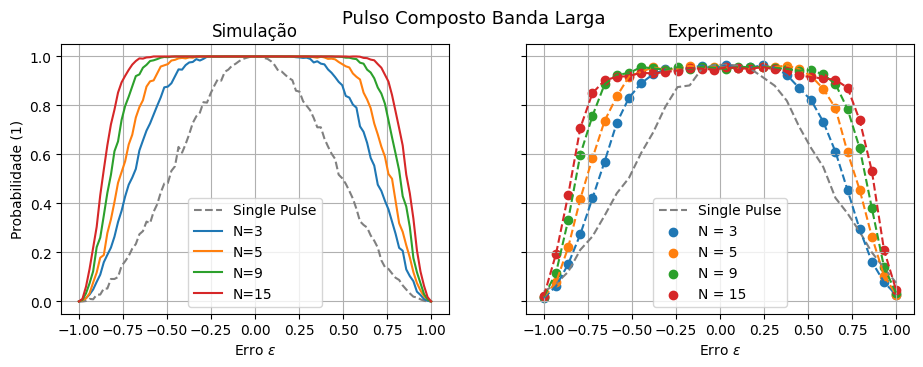

In [47]:

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (11,3.5), sharey = True)

ax1.plot(erro, prob_singlesim, '--', color = 'grey',label = 'Single Pulse' )
ax1.plot(erro,prob_sim_BB3, label = 'N=3')
ax1.plot(erro,prob_sim_BB5, label = 'N=5')
ax1.plot(erro,prob_sim_BB9, label = 'N=9')
ax1.plot(erro,prob_sim_BB15, label = 'N=15')



ax2.plot(list_erro, prob_single_pulse, '--',color = 'grey', label = 'Single Pulse')
ax2.scatter(list_erro, prob_BB3_amplitude, label = 'N = 3')
ax2.plot(list_erro, prob_BB3_amplitude, '--')
ax2.scatter(list_erro, probability_BB5_amplitude, label = 'N = 5')
ax2.plot(list_erro, probability_BB5_amplitude, '--')
ax2.scatter(list_erro, prob_BB9_amplitude, label = 'N = 9')
ax2.plot(list_erro, prob_BB9_amplitude, '--')
ax2.scatter(list_erro, prob_BB15_amplitude , label = 'N = 15')
ax2.plot(list_erro, prob_BB15_amplitude , '--')

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
plt.suptitle('Pulso Composto Banda Larga', fontsize = 13)
ax1.set_title('Simulação')
ax2.set_title('Experimento')

ax2.set_xlabel(r'Erro $\epsilon$')
ax1.set_xlabel(r'Erro $\epsilon$')
ax1.set_ylabel('Probabilidade (1)')

plt.savefig('BroadbandCP2.png')



plt.show()


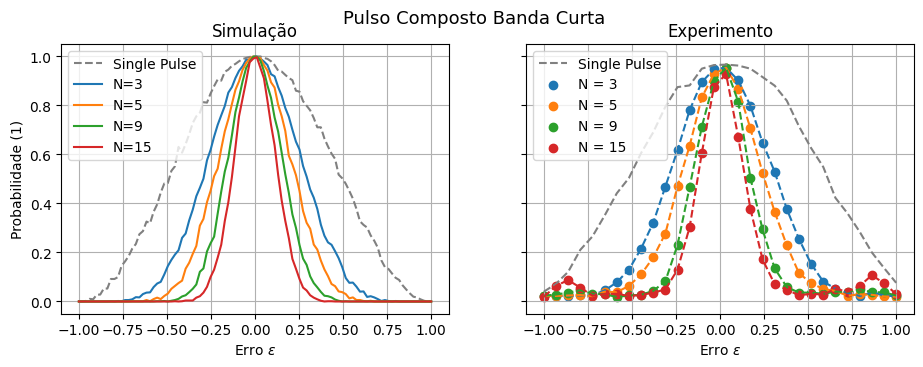

In [48]:
### Broadband:

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (11,3.5), sharey = True)

ax1.plot(erro, prob_singlesim, '--', color = 'grey',label = 'Single Pulse' )
ax1.plot(erro,prob_sim_NB3, label = 'N=3')
ax1.plot(erro,prob_sim_NB5, label = 'N=5')
ax1.plot(erro,prob_sim_NB9, label = 'N=9')
ax1.plot(erro,prob_sim_NB15, label = 'N=15')



ax2.plot(list_erro, prob_single_pulse, '--',color = 'grey', label = 'Single Pulse')
ax2.scatter(list_erro, prob_NB3_amplitude, label = 'N = 3')
ax2.plot(list_erro, prob_NB3_amplitude, '--')
ax2.scatter(list_erro, prob_NB5_amplitude, label = 'N = 5')
ax2.plot(list_erro, prob_NB5_amplitude, '--')
ax2.scatter(list_erro, prob_NB9_amplitude, label = 'N = 9')
ax2.plot(list_erro, prob_NB9_amplitude, '--')
ax2.scatter(list_erro, prob_try_15 , label = 'N = 15')
ax2.plot(list_erro, prob_try_15 , '--')

ax1.grid()
ax1.legend()
ax2.grid()
ax2.legend()
plt.suptitle('Pulso Composto Banda Curta', fontsize = 13)
ax1.set_title('Simulação')
ax2.set_title('Experimento')

ax2.set_xlabel(r'Erro $\epsilon$')
ax1.set_ylabel('Probabilidade (1)')
ax1.set_xlabel(r'Erro $\epsilon$')

plt.savefig('NarrowBandCP2.png')


plt.show()


### BB1 pulse
The Composite Pulse sequence BB1, may be defined as:
$$
R_\phi (\theta) ^{\text{ideal}} = R_\phi (\frac{\theta}{2}) R_{\phi + \beta} (\pi) R_{\phi + 3\beta} (2\pi) R_{\phi + \beta} (\pi) R_\phi (\frac{\theta}{2})
$$
With $\beta$:
$\beta = cos^{-1}(-\frac{\theta}{4\pi})$ 

OBS.: This job was ran in a separate notebook, where the error was defined going from $-0.9$ to $0.9$, with 31 points. Even though it differs from the choice of points here the main points still stands: BB1 is robust to amplitude errors. 

In [49]:
job_bb1 = session.job('cs1cf8nyhpyg008ah52g')

In [50]:
counts_bb1 = job_bb1.result().get_counts()
prob_bb1 = [i['1']/(sum(i.values())) for i in counts_bb1]

In [58]:
erro = np.linspace(-0.9, 0.9, 30)
erro = np.sort(np.append(0., erro))

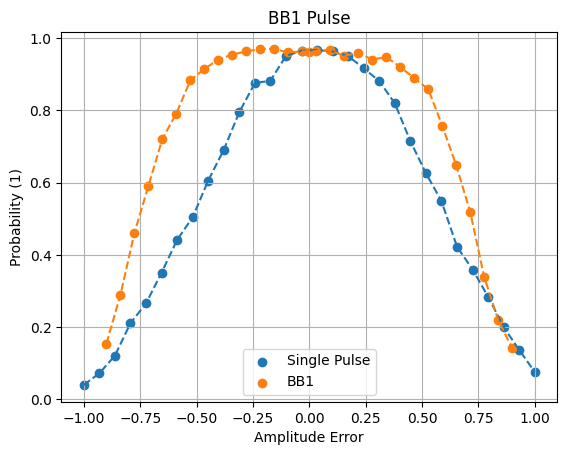

In [59]:
plt.scatter(list_erro, prob_single_pulse, label = 'Single Pulse')
plt.plot(list_erro, prob_single_pulse,'--')
plt.scatter(erro, prob_bb1, label = 'BB1')
plt.plot(erro, prob_bb1,'--')


plt.title('BB1 Pulse')
plt.xlabel('Amplitude Error')
plt.ylabel('Probability (1)')
plt.grid()
plt.legend()
plt.show()